# Experiments with rescaling images using SIREN activation function

## Author: Mathias Are

## Models reconfigured for colored images by Stephane Boire

### Used Vincent Sitzmann's explore_siren notebook from SIREN github repository: https://github.com/vsitzmann/siren




In [1]:


# NB! Only for Colab
#Imports files


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import random
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ToPILImage
import numpy as np
import skimage
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.measure import compare_mse as mse

import time
import image


In [ ]:
sidelength=32

In [13]:
def get_mgrid(sidelen, dim=2, depth=1):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])+(torch.linspace(-1, 1, steps=depth),)
    print(tensors[0].size(), tensors[1].size(), tensors[2].size())
    print(len(torch.meshgrid(*tensors)))
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    print("Mgrid step 2: ", mgrid.size())
    mgrid = mgrid.reshape(depth, sidelen**2, dim+1)
    print("Mgrid step 3: ", mgrid.size())
    return mgrid


def lin2img(tensor, image_resolution=None):
    batch_size, num_samples, channels = (512,512,3)
    if image_resolution is None:
        width = np.sqrt(num_samples).astype(int)
        height = width
    else:
        height = image_resolution[0]
        width = image_resolution[1]

    return tensor.permute(0, 2, 1).view(batch_size, channels, height, width)


def rescale_img(x, mode='scale', perc=None, tmax=1.0, tmin=0.0):
    if (mode == 'scale'):
        if perc is None:
            xmax = torch.max(x)
            xmin = torch.min(x)
        else:
            xmin = np.percentile(x.detach().cpu().numpy(), perc)
            xmax = np.percentile(x.detach().cpu().numpy(), 100 - perc)
            x = torch.clamp(x, xmin, xmax)
        if xmin == xmax:
            return 0.5 * torch.ones_like(x) * (tmax - tmin) + tmin
        x = ((x - xmin) / (xmax - xmin)) * (tmax - tmin) + tmin
    elif (mode == 'clamp'):
        x = torch.clamp(x, 0, 1)
    return x


In [14]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        #output=gradient(output, coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [15]:
#Methods for getting laplace and gradient for each pixel value

def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [16]:
#Image importing and transfromation to correct size

def get_image(img,sidelength=128):
    imgA = Image.fromarray(np.array(img))
    transform = Compose([
        Resize((sidelength, sidelength)),
        ToTensor()
        #Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    imgA = transform(imgA)
    imgA=imgA.permute(1, 2, 0)
    return imgA



In [17]:
#Object for image fitting

class ImageFitting(Dataset):
    def __init__(self, sidelength, img_input, nb_images=1):
        super().__init__()
        img = img_input.reshape(sidelength**2, 3)
        print("Pixels size: ", img.size())
        self.pixels = img
        self.coords = get_mgrid(sidelength, 2, depth=nb_images)
        print("Coords size: ", self.coords.size())

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > len(self.pixels): raise IndexError
            
        return self.coords, self.pixels

In [18]:
#Importing and fitting Images
def read_image(i,lr,hr,size):
  
  lr_image=lr[i]
  
  hr_image = hr[i]
  
  
  return (get_image(lr_image,size),get_image(hr_image,size))

#Initiating the network



In [19]:
def transform(data,sidelength=64):
  transform = Compose([
        Resize((sidelength, sidelength)),
        #Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
  data = transform(data)
  return data


In [20]:

losses=[]
def train_model(lr,hr,batch_size,total_steps=1000,steps_til_summary=250,size_img=64):
 
  #optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
  optim = torch.optim.Adam(lr=3e-6, params=img_siren.parameters())

  """model_input, ground_truth = next(iter(dataloader))
  ground_truth=ground_truth.resize(1, 1, size_img**2, 3)
  model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
  print("Input, output sizes; ", model_input.size(), ground_truth.size())
  print("Model_input: ", model_input[:3, :3])"""


  for step in range(total_steps):
    for k in range(batch_size):
      
      
      model_input,aim_output=read_image(k,lr,hr,64)

      #model_input, ground_truth = model_input.cuda(), ground_truth.cuda()


      model_output, coords = img_siren(model_input)
      reshaped1 = model_output
      reshaped2 = aim_output
      loss = ((reshaped1-reshaped2 )**2).mean()
      if (k==0):
        losses.append(loss)
      optim.zero_grad()
      loss.backward(retain_graph=True)
      optim.step()
      
      if not step % steps_til_summary:
          print("Step %d, Total loss %0.6f" % (step, loss))
          #skimage.io.imsave('/content/drive/MyDrive/data/model_results/train/image'+str (step)+str (k)+'.png',model_output.view(128,128, 3).detach().numpy())
    

In [21]:
#img_siren = Siren(in_features=3, out_features=3, hidden_features=256, 
         #         hidden_layers=3, outermost_linear=True)
#img_siren.cuda()

img_siren = Siren(in_features=3, out_features=3, hidden_features=128, 
                  hidden_layers=3, outermost_linear=True)


In [22]:
from skimage.io import imread_collection,imsave
import os
import re

def read_from_path(path):
  images = []
  dirFiles = os.listdir(path)
  dirFiles.sort(key=lambda f: int(re.sub('\D', '', f)))
  for filename in dirFiles:
    print(filename)
    img = Image.open(path+"/"+filename)


    if img is not None:
      
      images.append(img)
  return images

col_dir1 = '/content/drive/MyDrive/data/DIV2K_train_HR'
col_dir2 = "/content/drive/MyDrive/data/DIV2K_train_LR_x8"


hr = read_from_path(col_dir1)
lr = read_from_path(col_dir2)
for i,img in enumerate(lr):
  for x in range(10):
      img=img.resize((1000,1000),0)
      img=img.resize((32,32),0)
  lr[i]=img
      

print(len(hr))
print(len(lr))
for x in range(len(lr)):
  
  
  img1,img2=read_image(x,lr,hr,64)
  print(((img1-img2 )**2).mean())
  if(x==0):
    skimage.io.imsave('/content/drive/MyDrive/data/model_results/test1.png',img1.view(64,64, 3).detach().numpy())
    skimage.io.imsave('/content/drive/MyDrive/data/model_results/test2.png',img2.view(64,64, 3).detach().numpy())
    
    
    
  





0001.png
0002.png
0003.png
0004.png
0005.png
0006.png
0007.png
0008.png
0009.png
0010.png
0011.png
0012.png
0013.png
0014.png
0015.png
0016.png
0017.png
0018.png
0019.png
0020.png
0021.png
0022.png
0023.png
0024.png
0025.png
0026.png
0027.png
0028.png
0029.png
0030.png
0031.png
0032.png
0033.png
0034.png
0035.png
0036.png
0037.png
0038.png
0039.png
0040.png
0041.png
0042.png
0043.png
0044.png
0045.png
0046.png
0047.png
0048.png
0049.png
0050.png
0051.png
0052.png
0053.png
0054.png
0055.png
0056.png
0057.png
0058.png
0059.png
0060.png
0061.png
0062.png
0063.png
0064.png
0065.png
0066.png
0067.png
0068.png
0069.png
0070.png
0071.png
0072.png
0073.png
0074.png
0075.png
0076.png
0077.png
0078.png
0079.png
0080.png
0081.png
0082.png
0083.png
0084.png
0085.png
0086.png
0087.png
0088.png
0089.png
0090.png
0091.png
0092.png
0093.png
0094.png
0095.png
0096.png
0097.png
0098.png
0099.png
0100.png
0101.png
0102.png
0103.png
0104.png
0105.png
0106.png
0107.png
0108.png
0109.png
0110.png
0111.png
0

250
250
tensor(0.0039)
tensor(0.0017)
tensor(0.0066)
tensor(0.0018)
tensor(0.0069)
tensor(0.0057)
tensor(0.0040)
tensor(0.0069)
tensor(0.0125)
tensor(0.0049)
tensor(0.0062)
tensor(0.0123)
tensor(0.0019)
tensor(0.0072)
tensor(0.0078)
tensor(0.0044)
tensor(0.0058)
tensor(0.0121)
tensor(0.0106)
tensor(0.0046)
tensor(0.0078)
tensor(0.0062)
tensor(0.0023)
tensor(0.0088)
tensor(0.0041)
tensor(0.0116)
tensor(0.0039)
tensor(0.0066)
tensor(0.0078)
tensor(0.0055)
tensor(0.0051)
tensor(0.0018)
tensor(0.0102)
tensor(0.0154)
tensor(0.0028)
tensor(0.0023)
tensor(0.0043)
tensor(0.0100)
tensor(0.0025)
tensor(0.0012)
tensor(0.0042)
tensor(0.0074)
tensor(0.0034)
tensor(0.0096)
tensor(0.0064)
tensor(0.0035)
tensor(0.0057)
tensor(0.0015)
tensor(0.0032)
tensor(0.0084)
tensor(0.0033)
tensor(0.0064)
tensor(0.0043)
tensor(0.0032)
tensor(0.0014)
tensor(0.0066)
tensor(0.0015)
tensor(0.0069)
tensor(0.0022)
tensor(0.0082)
tensor(0.0028)
tensor(0.0020)
tensor(0.0101)
tensor(0.0027)
tensor(0.0019)
tensor(0.0053)
te

In [23]:


train_model(lr,hr,250,total_steps=500,steps_til_summary=250,size_img=64)

Step 0, Total loss 0.137241
Step 0, Total loss 0.145008
Step 0, Total loss 0.429376
Step 0, Total loss 0.460314
Step 0, Total loss 0.445089
Step 0, Total loss 0.196201
Step 0, Total loss 0.190486
Step 0, Total loss 0.362539
Step 0, Total loss 0.387722
Step 0, Total loss 0.241584
Step 0, Total loss 0.237172
Step 0, Total loss 0.201197
Step 0, Total loss 0.095763
Step 0, Total loss 0.287624
Step 0, Total loss 0.221955
Step 0, Total loss 0.376799
Step 0, Total loss 0.337943
Step 0, Total loss 0.228072
Step 0, Total loss 0.172866
Step 0, Total loss 0.135400
Step 0, Total loss 0.289843
Step 0, Total loss 0.265131
Step 0, Total loss 0.199479
Step 0, Total loss 0.156288
Step 0, Total loss 0.155224
Step 0, Total loss 0.220486
Step 0, Total loss 0.178835
Step 0, Total loss 0.354667
Step 0, Total loss 0.126178
Step 0, Total loss 0.305582
Step 0, Total loss 0.257222
Step 0, Total loss 0.326419
Step 0, Total loss 0.242009
Step 0, Total loss 0.218296
Step 0, Total loss 0.252467
Step 0, Total loss 0

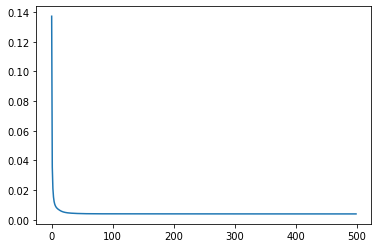

In [24]:
plt.plot(losses)

0.010969113441945405


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
  """


In [25]:
def read_from_path(path):
  images = []
  dirFiles = os.listdir(path)
  dirFiles.sort(key=lambda f: int(re.sub('\D', '', f)))
  for filename in dirFiles:
    print(filename)
    img = Image.open(path+"/"+filename)


    if img is not None:
      images.append(img)
  return images

col_dir3 = '/content/drive/MyDrive/data/DIV2K_valid_LR_x8'
col_dir4 = "/content/drive/MyDrive/data/DIV2K_valid_HR"


lr_val = read_from_path(col_dir3)
hr_val = read_from_path(col_dir4)
for i,img in enumerate(lr_val):
  for x in range(10):
      img=img.resize((1000,1000),0)
      img=img.resize((32,32),0)
  lr_val[i]=img

print(len(hr))
print(len(lr))





0801x8.png
0802x8.png
0803x8.png
0804x8.png
0805x8.png
0806x8.png
0807x8.png
0808x8.png
0809x8.png
0810x8.png
0811x8.png
0812x8.png
0813x8.png
0814x8.png
0815x8.png
0816x8.png
0817x8.png
0818x8.png
0819x8.png
0820x8.png
0821x8.png
0822x8.png
0823x8.png
0824x8.png
0825x8.png
0826x8.png
0827x8.png
0828x8.png
0829x8.png
0830x8.png
0801.png
0802.png
0803.png
0804.png
0805.png
0806.png
0807.png
0808.png
0809.png
0810.png
0811.png
0812.png
0813.png
0814.png
0815.png
0816.png
0817.png
0818.png
0819.png
0820.png
0821.png
0822.png
0823.png
0824.png
0825.png
0826.png
0827.png
0828.png
0829.png
0830.png
250
250


ORIGINAL LOSS:  0.006072598043829203
Loss after training 0.006010
Difference,  0.0001


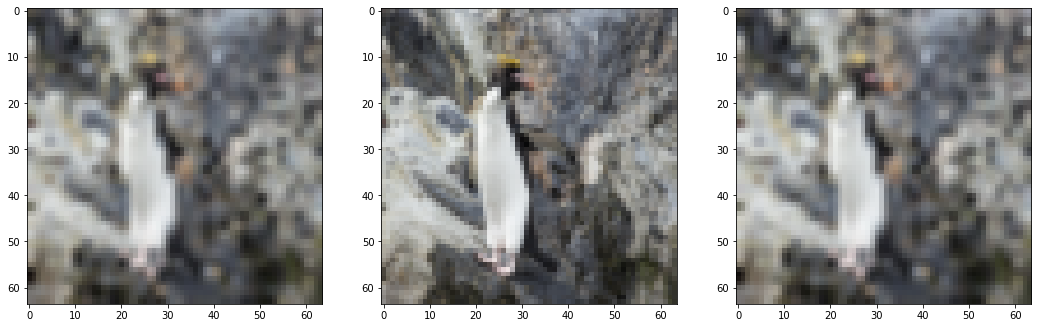

ORIGINAL LOSS:  0.008120826445519924
Loss after training 0.008642
Difference,  -0.0005


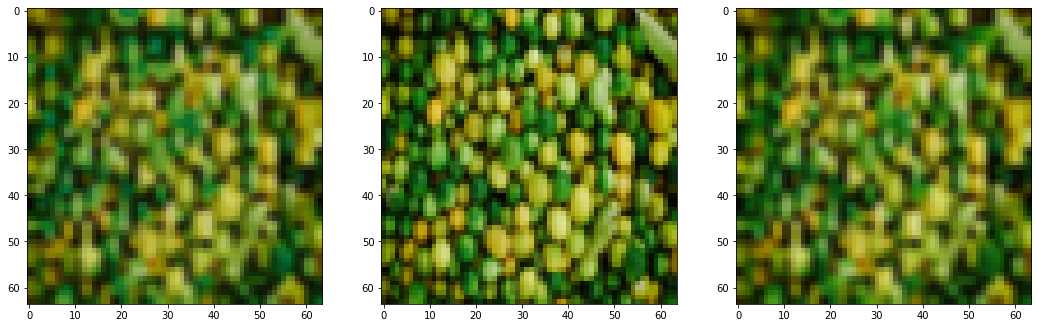

ORIGINAL LOSS:  0.0038693288806825876
Loss after training 0.004710
Difference,  -0.0008


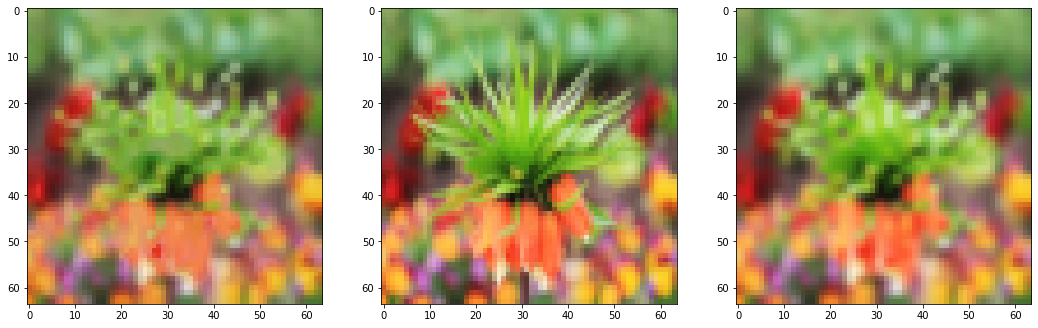

ORIGINAL LOSS:  0.010660961270332336
Loss after training 0.010337
Difference,  0.0003


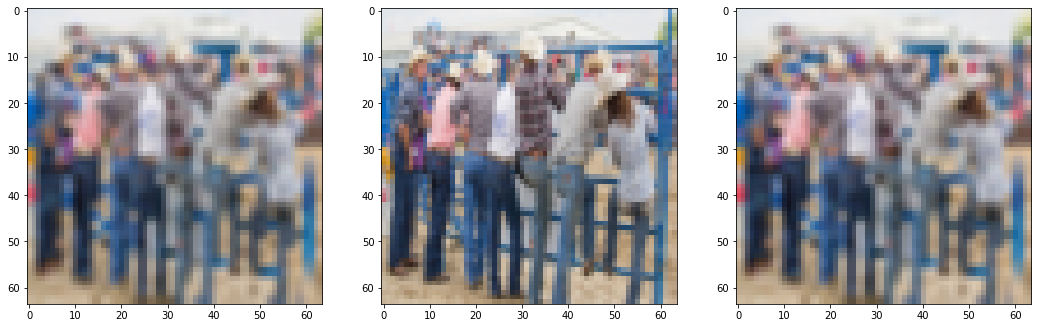

ORIGINAL LOSS:  0.003969313111156225
Loss after training 0.004142
Difference,  -0.0002


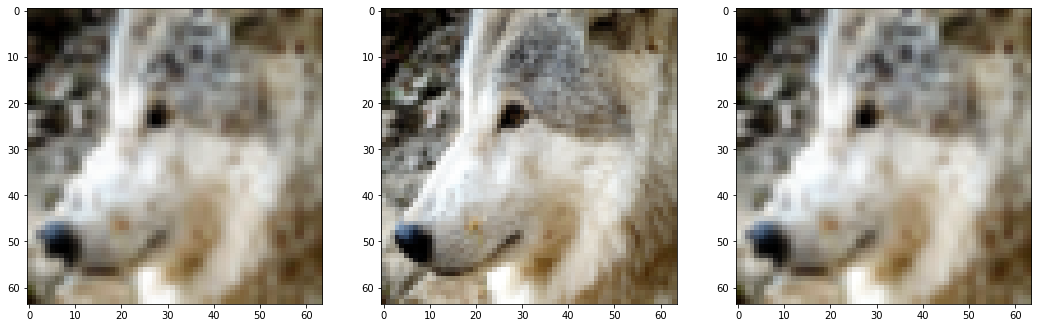

ORIGINAL LOSS:  0.003987108822911978
Loss after training 0.004031
Difference,  0.0


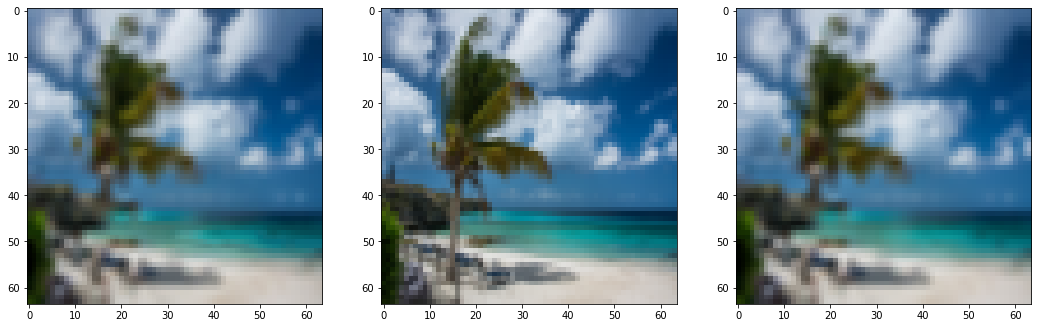

ORIGINAL LOSS:  0.0052171796560287476
Loss after training 0.006164
Difference,  -0.0009


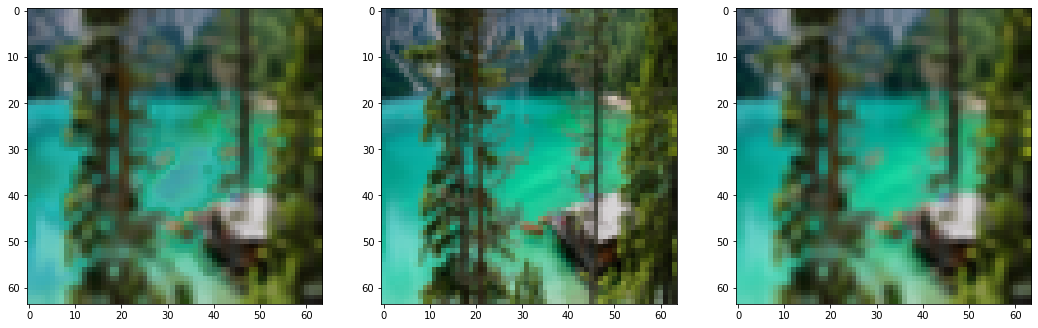

ORIGINAL LOSS:  0.003985298797488213
Loss after training 0.004549
Difference,  -0.0006


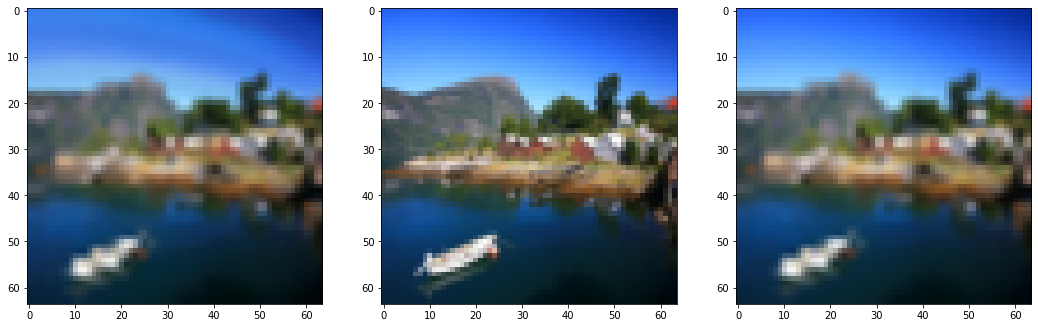

ORIGINAL LOSS:  0.0032215965911746025
Loss after training 0.003379
Difference,  -0.0002


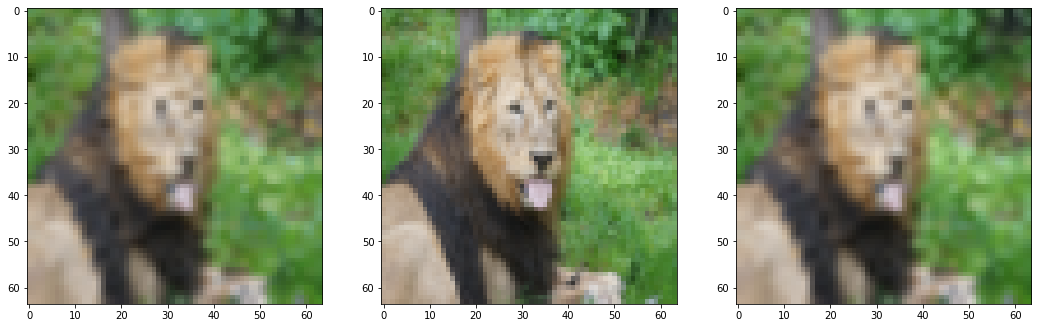

ORIGINAL LOSS:  0.002270817756652832
Loss after training 0.002331
Difference,  -0.0001


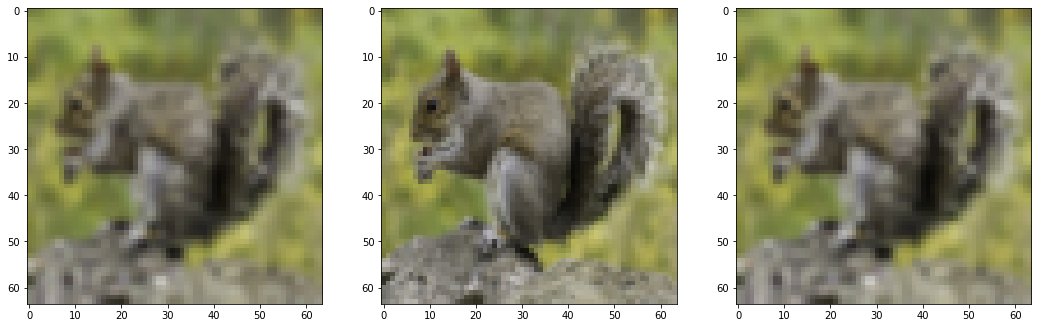

ORIGINAL LOSS:  0.0026257920544594526
Loss after training 0.002705
Difference,  -0.0001


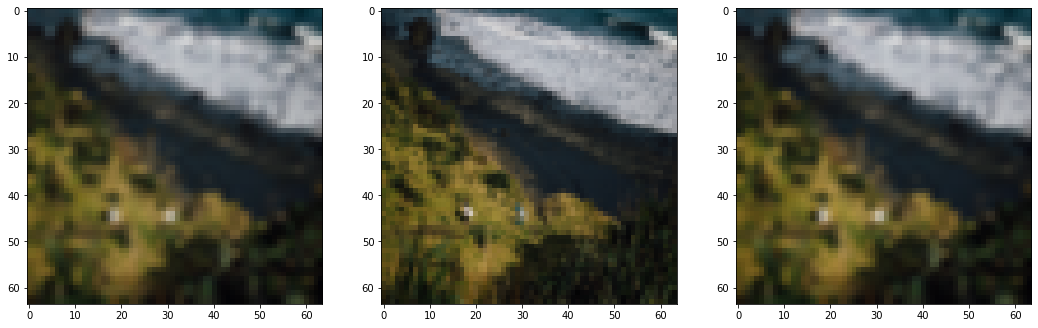

ORIGINAL LOSS:  0.008369087241590023
Loss after training 0.008389
Difference,  0.0


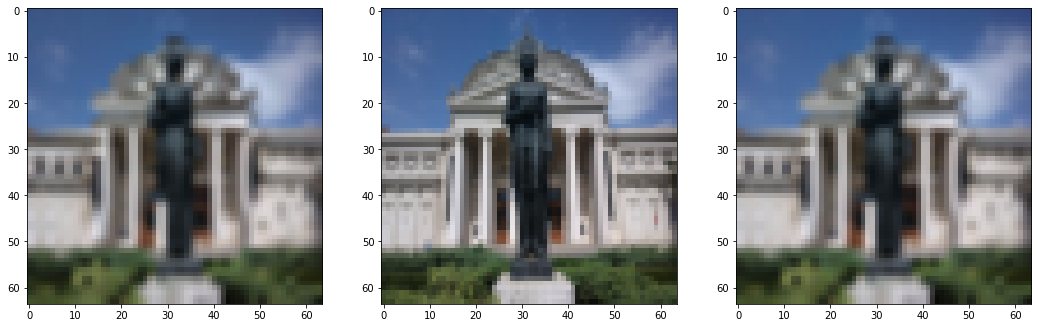

ORIGINAL LOSS:  0.006873394828289747
Loss after training 0.007225
Difference,  -0.0004


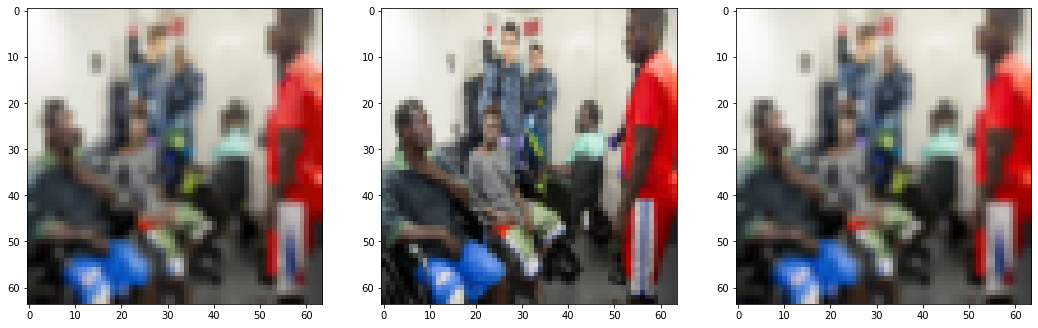

ORIGINAL LOSS:  0.002593119628727436
Loss after training 0.002581
Difference,  0.0


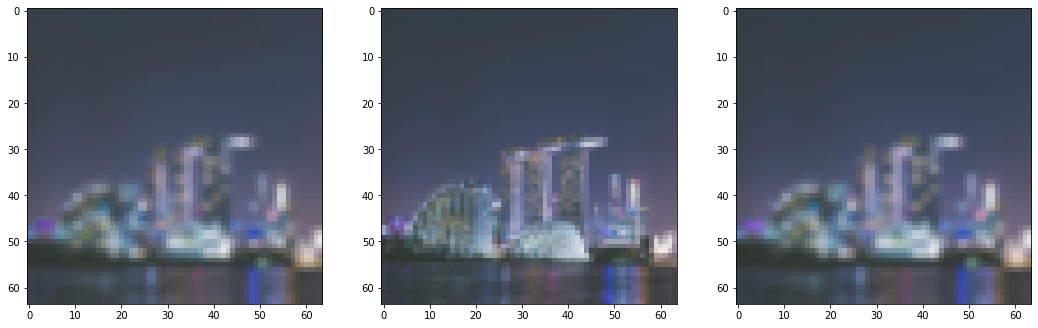

ORIGINAL LOSS:  0.0055979532189667225
Loss after training 0.005604
Difference,  0.0


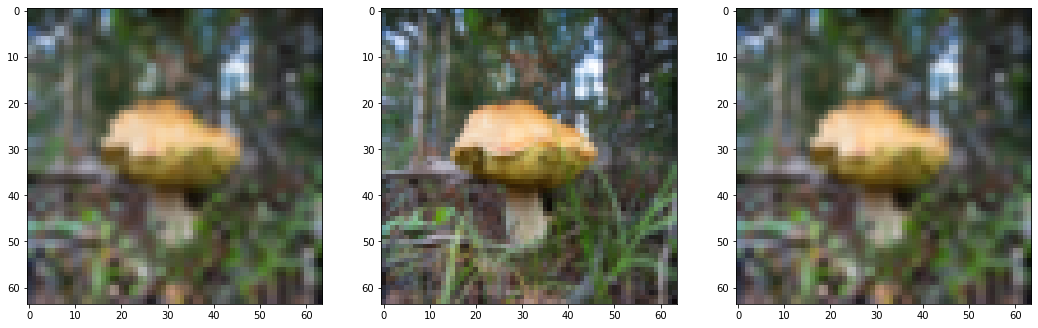

ORIGINAL LOSS:  0.0032935512717813253
Loss after training 0.003189
Difference,  0.0001


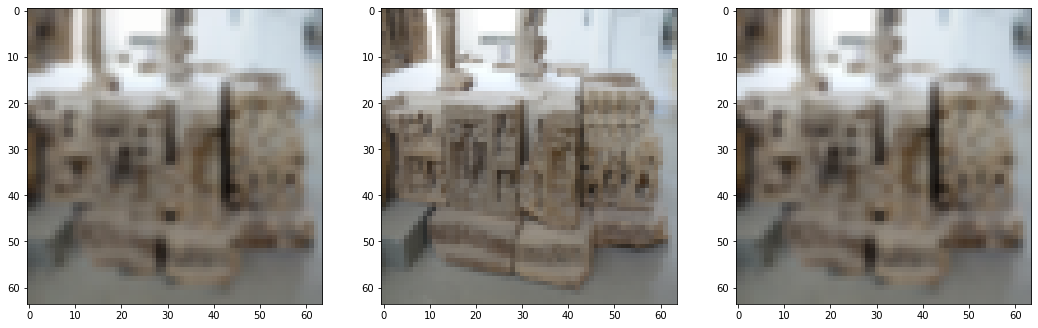

ORIGINAL LOSS:  0.005366528406739235
Loss after training 0.005423
Difference,  -0.0001


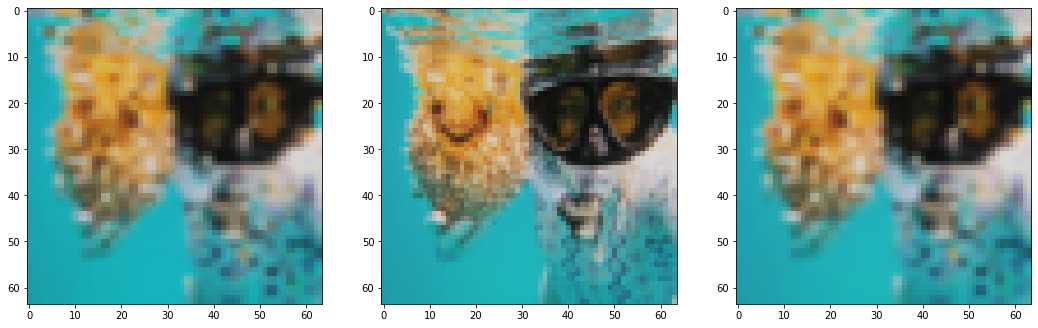

ORIGINAL LOSS:  0.007603507023304701
Loss after training 0.007666
Difference,  -0.0001


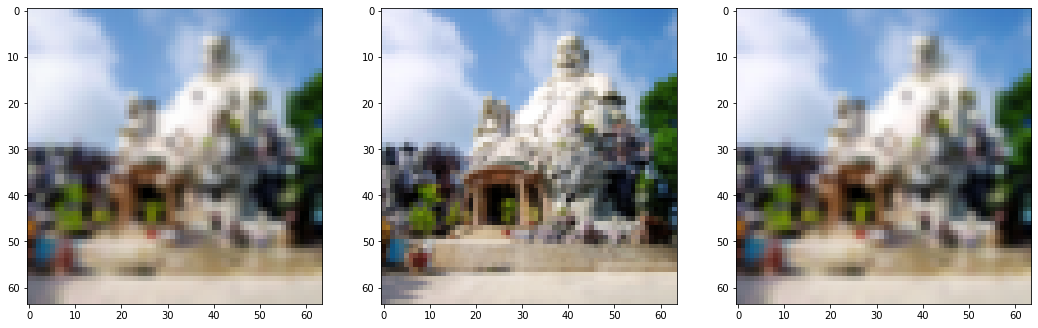

ORIGINAL LOSS:  0.0057971905916929245
Loss after training 0.005706
Difference,  0.0001


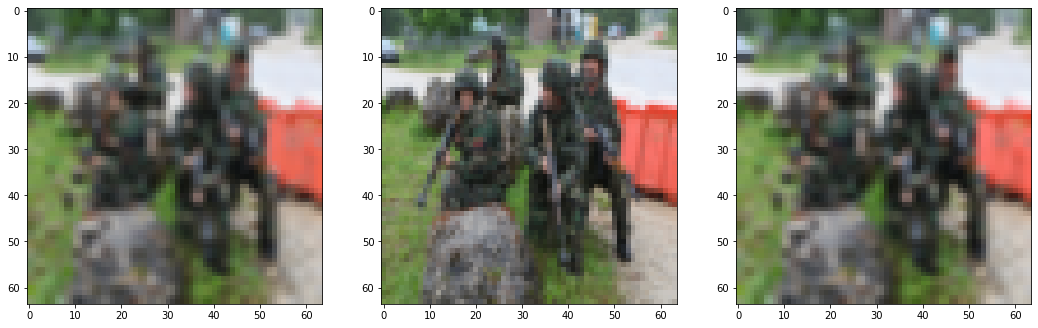

ORIGINAL LOSS:  0.011656573973596096
Loss after training 0.011652
Difference,  0.0


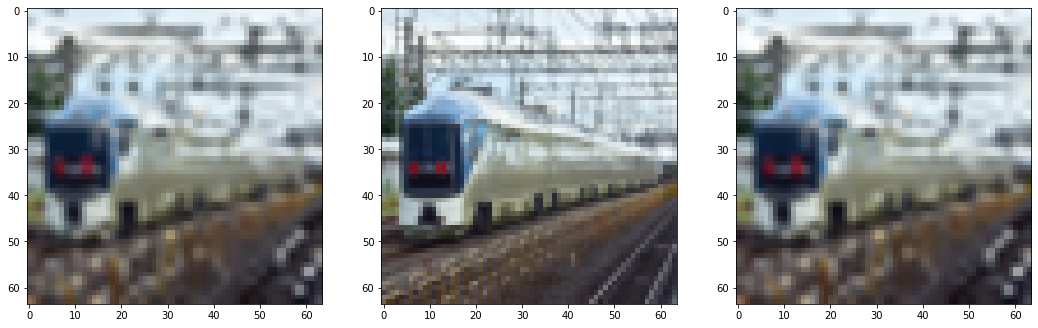

ORIGINAL LOSS:  0.020374447107315063
Loss after training 0.019670
Difference,  0.0007


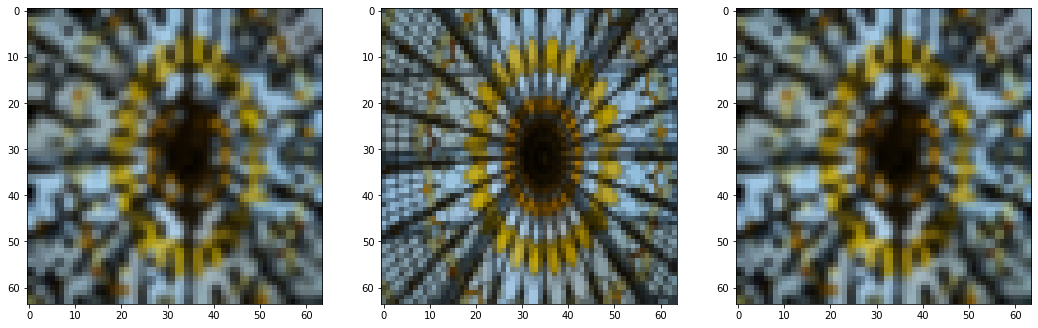

ORIGINAL LOSS:  0.004873603582382202
Loss after training 0.004799
Difference,  0.0001


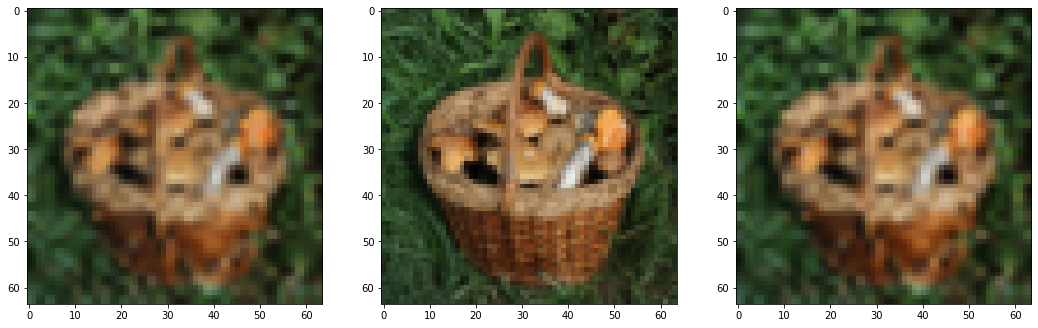

ORIGINAL LOSS:  0.005121948197484016
Loss after training 0.005058
Difference,  0.0001


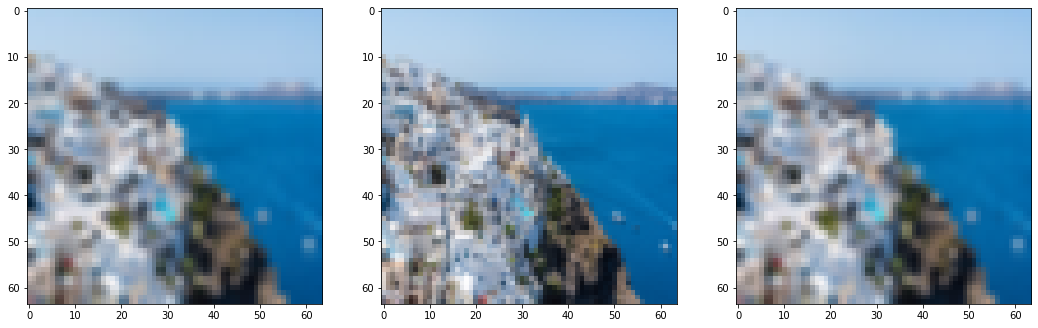

ORIGINAL LOSS:  0.009688847698271275
Loss after training 0.009655
Difference,  0.0


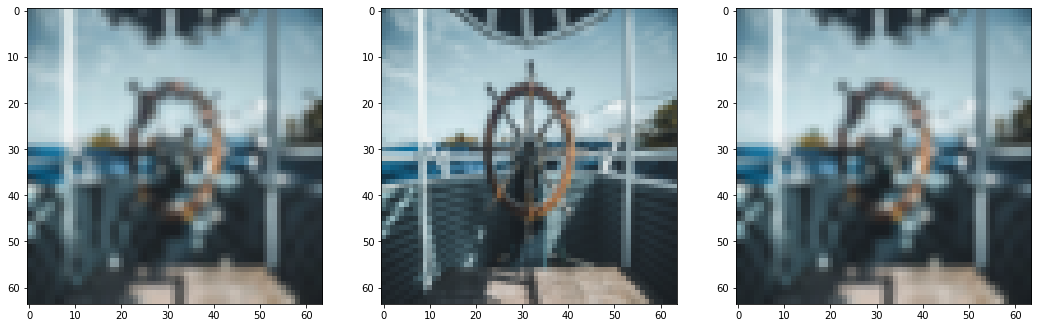

ORIGINAL LOSS:  0.01196176279336214
Loss after training 0.011610
Difference,  0.0004


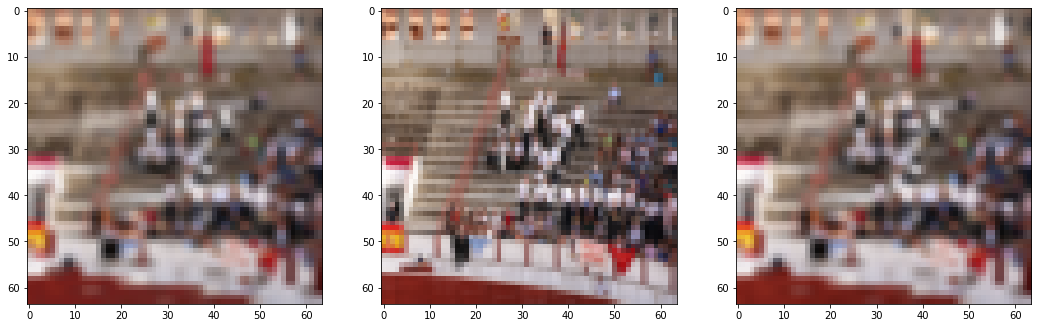

ORIGINAL LOSS:  0.006496924441307783
Loss after training 0.006413
Difference,  0.0001


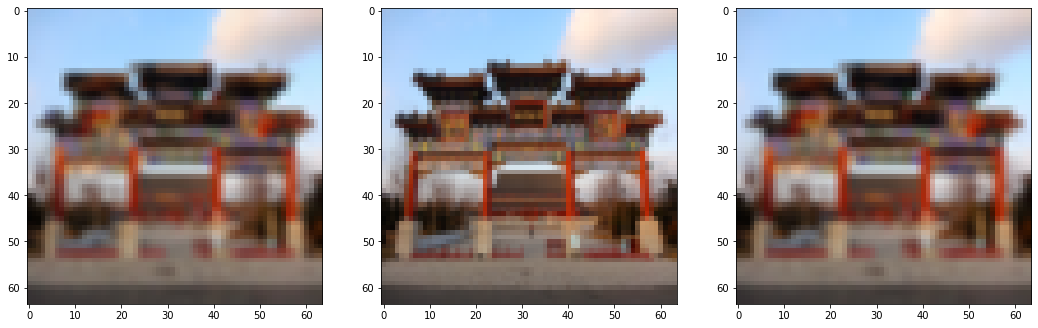

ORIGINAL LOSS:  0.0016608834266662598
Loss after training 0.001649
Difference,  0.0


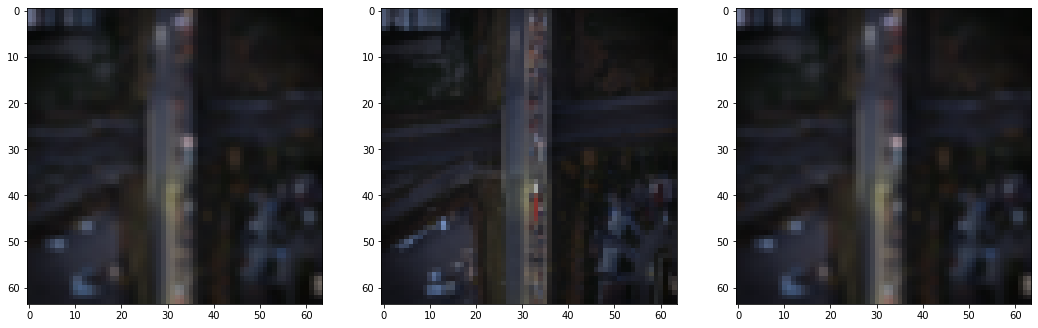

ORIGINAL LOSS:  0.0052791014313697815
Loss after training 0.005386
Difference,  -0.0001


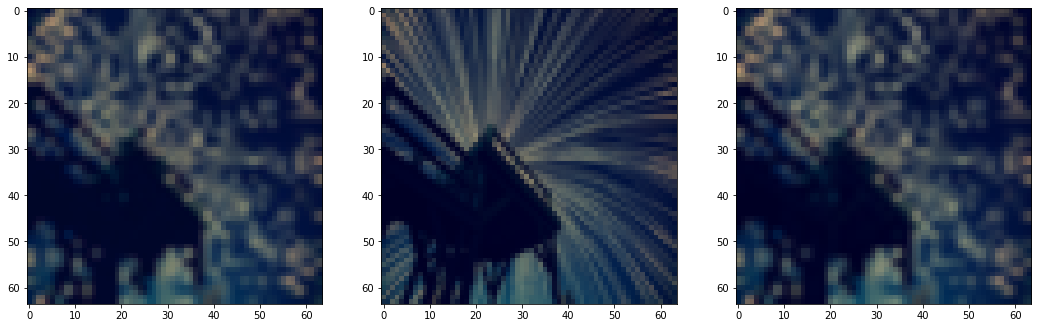

ORIGINAL LOSS:  0.004942246247082949
Loss after training 0.005014
Difference,  -0.0001


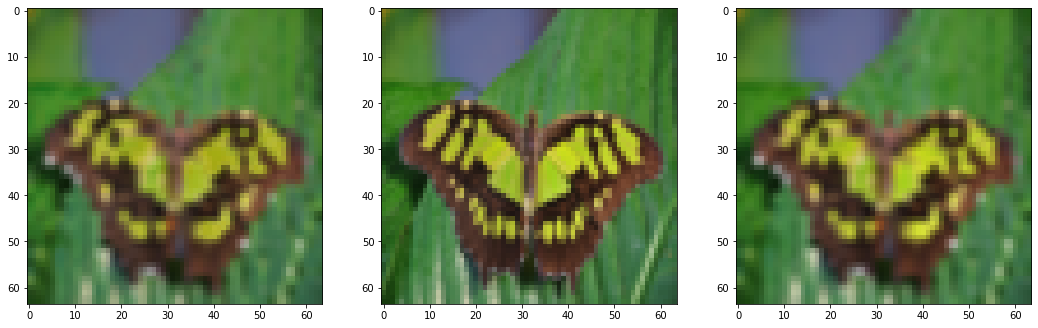

ORIGINAL LOSS:  0.003107695607468486
Loss after training 0.003158
Difference,  -0.0001


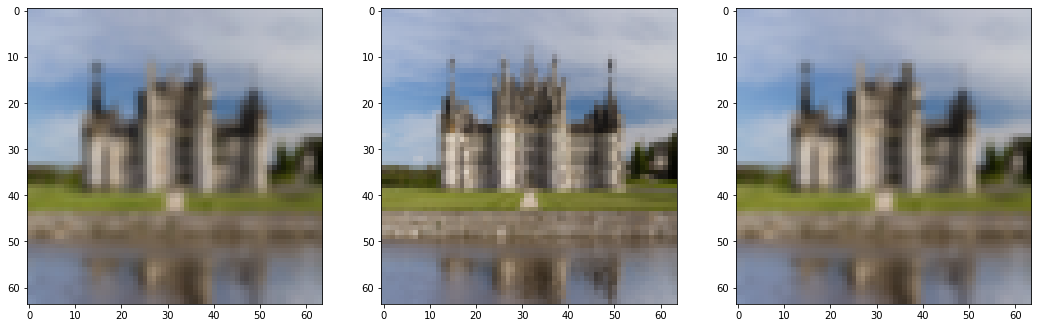

In [26]:
for x in range(30):
  model_input,aim_output=read_image(x,lr_val,hr_val,64)
  model_output, coords = img_siren(model_input)
  reshaped1 = model_output
  reshaped2 = aim_output
  loss = float (((reshaped1-reshaped2 )**2).mean())
  original_loss =float (((model_input-aim_output )**2).mean())
  diff = original_loss-loss
  print("ORIGINAL LOSS: ",original_loss)
  print("Loss after training %0.6f" % loss)
  print("Difference, ",round(diff*10000)/10000)
  fig, axes = plt.subplots(1,3, figsize=(18,6))
  #print("Size image: ", model_output.cpu()[:1, :16384, :].size())
  axes[0].imshow(model_output.cpu().view(64,64, 3).detach().numpy())
  axes[1].imshow(aim_output.cpu().view(64,64, 3).detach().numpy())
  axes[2].imshow(model_input.cpu().view(64,64, 3).detach().numpy())
          #axes[2].imshow(img_laplacian.cpu()[:, :1].view(size_img,size_img).detach().numpy())
  plt.show()


(255, 169)


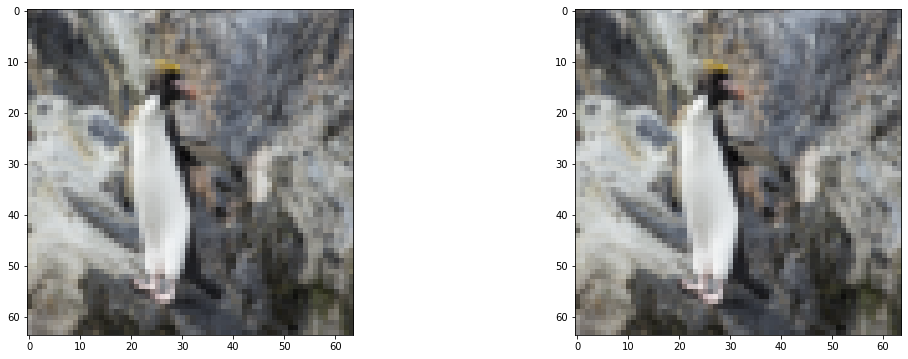

In [ ]:
get_image(lr_val[0])
print(lr_val[0].size)

fig, axes = plt.subplots(1,2, figsize=(18,6))
axes[0].imshow(get_image(hr_val[0],64).view(64,64, 3).detach().numpy())
axes[1].imshow(get_image(lr_val[0],64).view(64,64, 3).detach().numpy())